# **Hotel Recommendation System**

In [27]:
!pip install surprise
!pip install lightfm

## **Import libraries**

In [28]:
# To store the data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt

# To create interactive plots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To shift lists
from collections import deque

# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# To use recommender systems
import surprise as sp
from surprise.model_selection import cross_validate

# To create deep learning models
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

# To create sparse matrices
from scipy.sparse import coo_matrix

# To light fm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

# To stack sparse matrices
from scipy.sparse import vstack

## **Read dataset**

In [92]:
# Load a hotel metadata dataset
ratings = pd.read_csv('/content/dataset_final.csv')

print('Shape ratings:\t{}'.format(ratings.shape))
ratings.sample(5)

Shape ratings:	(2231, 10)


,User_name,Location_hotel,Hotel_name,Rating,Comment,Service,Infrastructure,Sanitary,Location,Attitude
2138,Tran P. T.,Hội An,Hội An Reverie Villas,8.2,cũng khá ổn với giá tiền tuy_nhiên ban_đêm còn...,0,0,1,0,1
3,Dang T. D.,Đà Lạt,Khách Sạn LADALAT,6.0,khách_sạn hơi xa trung_tâm phòng_ốc tốt buffet...,1,1,0,1,1
900,Nguyen Q. T.,Nha Trang,Vinpearl Condotel Beachfront Nha Trang,8.0,các dịch_vụ tốt nhưng diện_tích phòng lần này ...,1,1,0,0,1
1548,Nguyen T. B. T.,Phan Thiết,Sea Links Beach Villas Phan Thiết,8.5,chuyến đi của tôi rất vui_vẻ cảm_ơn ivivu đã đ...,0,1,0,0,2
530,Quyen Q.,Đà Nẵng,Khách sạn Brown Bean,6.0,việc nhận_phòng quá chậm mà không_biết lỗi từ ...,1,0,0,0,0


<Figure size 1200x800 with 0 Axes>

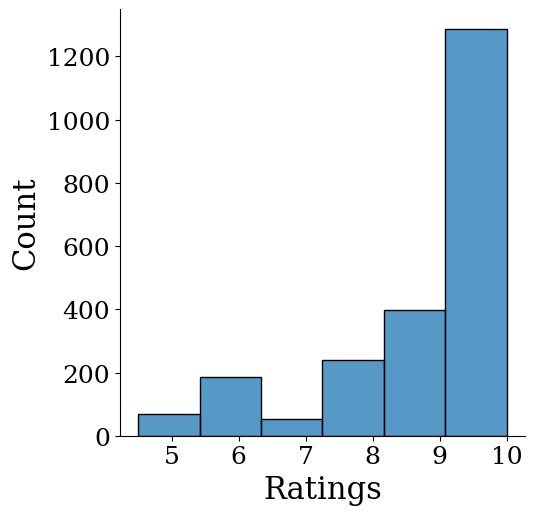

In [30]:
plt.figure(figsize=(12, 8))
sns.displot(x=ratings["Rating"],bins=6)

plt.xlabel('Ratings', fontsize=22, fontfamily='serif')
plt.ylabel('Count', fontsize=22, fontfamily='serif')

plt.xticks(fontsize=18, fontfamily='serif')
plt.yticks(fontsize=18, fontfamily='serif')

plt.show()

## **Preprocess Data**

In [93]:
# Filter sparse hotels
min_hotel_ratings = 0
filter_hotels = (ratings['Hotel_name'].value_counts()>min_hotel_ratings)
filter_hotels = filter_hotels[filter_hotels].index.tolist()

# Filter sparse users
min_user_ratings = 0
filter_users = (ratings['User_name'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filterd = ratings[(ratings['Hotel_name'].isin(filter_hotels)) & (ratings['User_name'].isin(filter_users))]
del filter_hotels, filter_users, min_hotel_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(ratings.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filterd.shape))

Shape User-Ratings unfiltered:	(2231, 10)
Shape User-Ratings filtered:	(2231, 10)


In [94]:
ratings = ratings.loc[:,['User_name','Hotel_name','Service', 'Infrastructure',	'Sanitary',	'Location',	'Attitude', 'Rating']]
ratings

,User_name,Hotel_name,Service,Infrastructure,Sanitary,Location,Attitude,Rating
0,Nguyen V. C.,Khu nghỉ dưỡng Pandanus Phan Thiết,0,0,0,0,2,10.0
1,Nguyen T. A. T.,Vinpearl Resort & Spa Phú Quốc,1,0,0,0,2,8.5
2,Tran T. M. T.,Victoria Phan Thiết Beach Resort & Spa,0,0,0,0,2,9.0
3,Dang T. D.,Khách Sạn LADALAT,1,1,0,1,1,6.0
4,Nguyen T. M. H.,Sea Links Beach Villas Phan Thiết,0,0,0,0,2,8.7
...,...,...,...,...,...,...,...,...
2226,Do T. H.,Khu nghỉ dưỡng Núi Thần Tài Ebisu Đà Nẵng,1,1,0,0,2,8.0
2227,Nguyen T. T. H.,Hong Thien 1 Hotel,1,0,1,0,0,6.0
2228,Phan T. L.,Khu nghỉ dưỡng Muine Bay Phan Thiết,1,0,0,0,2,10.0
2229,Nguyen T. M. C.,Khu nghỉ dưỡng Pandanus Phan Thiết,1,1,0,0,2,9.0


In [95]:
# tokenize User_name, Hotel_name
user_ids = ratings["User_name"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}

hotel_ids = ratings["Hotel_name"].unique().tolist()
hotel2hotel_encoded = {x: i for i, x in enumerate(hotel_ids)}
hotel_encoded2hotel = {i: x for i, x in enumerate(hotel_ids)}

ratings["UserID"] = ratings["User_name"].map(user2user_encoded)
ratings["HotelID"] = ratings["Hotel_name"].map(hotel2hotel_encoded)

num_users = len(user2user_encoded)
num_hotels = len(hotel2hotel_encoded)
ratings["Rating"] = ratings["Rating"].values.astype(np.float32)

min_rating = min(ratings["Rating"])
max_rating = max(ratings["Rating"])

print("Number of users: {}, Number of hotels: {}, Min rating: {}, Max rating: {}".format(num_users, num_hotels, min_rating, max_rating))

Number of users: 368, Number of hotels: 137, Min rating: 4.5, Max rating: 10.0


In [96]:
ratings

,User_name,Hotel_name,Service,Infrastructure,Sanitary,Location,Attitude,Rating,UserID,HotelID
0,Nguyen V. C.,Khu nghỉ dưỡng Pandanus Phan Thiết,0,0,0,0,2,10.0,0,0
1,Nguyen T. A. T.,Vinpearl Resort & Spa Phú Quốc,1,0,0,0,2,8.5,1,1
2,Tran T. M. T.,Victoria Phan Thiết Beach Resort & Spa,0,0,0,0,2,9.0,2,2
3,Dang T. D.,Khách Sạn LADALAT,1,1,0,1,1,6.0,3,3
4,Nguyen T. M. H.,Sea Links Beach Villas Phan Thiết,0,0,0,0,2,8.7,4,4
...,...,...,...,...,...,...,...,...,...,...
2226,Do T. H.,Khu nghỉ dưỡng Núi Thần Tài Ebisu Đà Nẵng,1,1,0,0,2,8.0,255,47
2227,Nguyen T. T. H.,Hong Thien 1 Hotel,1,0,1,0,0,6.0,181,54
2228,Phan T. L.,Khu nghỉ dưỡng Muine Bay Phan Thiết,1,0,0,0,2,10.0,263,29
2229,Nguyen T. M. C.,Khu nghỉ dưỡng Pandanus Phan Thiết,1,1,0,0,2,9.0,159,0


In [97]:
# Normalize rating vào khoảng [0, 1]
ratings["Rating"] = ratings["Rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [98]:
from sklearn.model_selection import train_test_split

ratings, ratings_test, _, _ = train_test_split(ratings,ratings, random_state=42, test_size=0.2)

In [99]:
ratings

,User_name,Hotel_name,Service,Infrastructure,Sanitary,Location,Attitude,Rating,UserID,HotelID
1988,Le Q. H.,Khu nghỉ dưỡng Melia Đà Nẵng Beach,0,0,0,0,2,1.000000,168,71
1996,Nguyen T. H. L.,Khu nghỉ dưỡng Vinpearl Nha Trang,1,1,0,0,2,0.454545,363,57
1581,Thu L.,Ma Coeur Boutique Hotel,1,1,1,0,2,0.945455,302,56
1904,Nguyen T. M. H.,Khách sạn Mường Thanh Luxury Khánh Hòa,1,1,1,0,2,0.945455,4,67
1426,Do T. T.,Khu nghỉ dưỡng Fusion Phú Quốc,1,0,0,0,2,1.000000,248,83
...,...,...,...,...,...,...,...,...,...,...
1638,Nguyen V. T.,Vinpearl Resort & Spa Phú Quốc,1,1,1,0,2,0.636364,63,1
1095,Nguyen T. M. H.,Khách sạn Royal Vũng Tàu,1,0,0,1,2,0.727273,4,55
1130,Mai T. N.,Khu nghỉ dưỡng Crown Retreat Quy Nhơn,1,0,0,1,2,1.000000,216,65
1294,Nguyen M. P.,Khu nghỉ dưỡng Pandanus Phan Thiết,1,0,0,0,2,1.000000,338,0


In [100]:
ratings_test

,User_name,Hotel_name,Service,Infrastructure,Sanitary,Location,Attitude,Rating,UserID,HotelID
1547,Vu T. T.,Khách sạn Fusion Suites Vũng Tàu,1,0,0,0,0,0.636364,20,92
1411,Pham T.,Khu nghỉ dưỡng Ana Mandara Villas Dalat Resort...,1,0,0,0,2,0.636364,300,36
480,Nguyen T. H. H.,Meliã Vinpearl Đà Nẵng Riverfront,1,1,0,0,2,1.000000,221,28
617,Nguyen T. L.,Khu nghỉ dưỡng Fusion Phú Quốc,1,1,0,0,2,1.000000,193,83
1489,Nguyen Q. T.,Khu nghỉ dưỡng Seava Hồ Tràm,1,0,0,0,0,1.000000,249,81
...,...,...,...,...,...,...,...,...,...,...
1040,Vo M. T.,Khu nghỉ dưỡng Fusion Phú Quốc,1,0,0,0,2,0.636364,87,83
1268,Tran T. V.,Muong Thanh Quy Nhon Hotel,1,0,0,0,2,0.945455,57,102
464,Tran T. V.,Khu nghỉ dưỡng Ana Mandara Villas Dalat Resort...,1,1,0,0,1,0.636364,57,36
1669,Vu T. H.,Seahorse Resort & Spa Phan Thiết,1,1,0,0,0,0.636364,33,8


### Save

In [102]:
ratings.to_csv('ratings_train.csv')
ratings_test.to_csv('ratings_test.csv')

## **Collaborative Filtering**

### **Matrix factorization**

#### **Modeling**

In [39]:
# Get input variable-sizes
users = len(user2user_encoded)
hotels = len(user_encoded2user)
embedding_size = 15

##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
hotel_id_input = Input(shape=[1], name='hotel')

# Create embedding layers for users and hotels
user_embedding = Embedding(output_dim=embedding_size,
                           input_dim=users,
                           input_length=1,
                           name='user_embedding')(user_id_input)
hotel_embedding = Embedding(output_dim=embedding_size,
                            input_dim=hotels,
                            input_length=1,
                            name='item_embedding')(hotel_id_input)

# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
hotel_vector = Reshape([embedding_size])(hotel_embedding)

# Compute dot-product of reshaped embedding layers as prediction
y = Dot(1, normalize=True)([user_vector, hotel_vector])

# Setup model
model = Model(inputs=[user_id_input, hotel_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')


# Fit model
model.fit([ratings['UserID'], ratings['HotelID']],
          ratings['Rating'],
          batch_size=20,
          epochs=100,
          validation_split=0.2,
          shuffle=True)

Epoch 1/100
72/72 [==============================] - 2s 9ms/step - loss: 0.7557 - val_loss: 0.6811
Epoch 2/100
72/72 [==============================] - 1s 8ms/step - loss: 0.4697 - val_loss: 0.6316
Epoch 3/100
72/72 [==============================] - 0s 6ms/step - loss: 0.3018 - val_loss: 0.5695
Epoch 4/100
72/72 [==============================] - 0s 5ms/step - loss: 0.1973 - val_loss: 0.5003
Epoch 5/100
72/72 [==============================] - 0s 4ms/step - loss: 0.1316 - val_loss: 0.4295
Epoch 6/100
72/72 [==============================] - 0s 5ms/step - loss: 0.0888 - val_loss: 0.3739
Epoch 7/100
72/72 [==============================] - 0s 6ms/step - loss: 0.0616 - val_loss: 0.3247
Epoch 8/100
72/72 [==============================] - 0s 7ms/step - loss: 0.0446 - val_loss: 0.2885
Epoch 9/100
72/72 [==============================] - 1s 8ms/step - loss: 0.0337 - val_loss: 0.2589
Epoch 10/100
72/72 [==============================] - 0s 6ms/step - loss: 0.0263 - val_loss: 0.2365
Epoch 11/

#### **Evaluating**

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Test model
y_pred = model.predict([ratings_test['UserID'], ratings_test['HotelID']])
y_true = ratings_test['Rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))

print('\n\nTesting Result With Keras Matrix-Factorization: {:.4f} MSE'.format(mean_squared_error(y_pred,y_true)))
print('\n\nTesting Result With Keras Matrix-Factorization: {:.4f} RMSE'.format(rmse))
print('\n\nTesting Result With Keras Matrix-Factorization: {:.4f} MAE'.format(mean_absolute_error(y_pred,y_true)))

14/14 [==============================] - 0s 2ms/step


Testing Result With Keras Matrix-Factorization: 0.1056 MSE


Testing Result With Keras Matrix-Factorization: 0.3250 RMSE


Testing Result With Keras Matrix-Factorization: 0.2449 MAE


### **Distributed Deep Learning (ALS)**

#### **Modeling**

In [43]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=91a748b25e6b5eb021f8a853c5ea90622712956dabe01bfab51b3da78a846821
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [161]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

from pyspark.sql import SparkSession

In [162]:
spark = SparkSession.builder.appName('Recommendation_System').getOrCreate()

In [163]:
ratings_train = spark.read.csv('ratings_train.csv',inferSchema=True,header=True)
ratings_test = spark.read.csv('ratings_test.csv',inferSchema=True,header=True)

In [164]:
ratings_train.show()

+----+---------------+--------------------+-------+--------------+--------+--------+--------+-------------------+------+-------+
| _c0|      User_name|          Hotel_name|Service|Infrastructure|Sanitary|Location|Attitude|             Rating|UserID|HotelID|
+----+---------------+--------------------+-------+--------------+--------+--------+--------+-------------------+------+-------+
|1988|       Le Q. H.|Khu nghỉ dưỡng Me...|      0|             0|       0|       0|       2|                1.0|   168|     71|
|1996|Nguyen T. H. L.|Khu nghỉ dưỡng Vi...|      1|             1|       0|       0|       2|0.45454545454545453|   363|     57|
|1581|         Thu L.|Ma Coeur Boutique...|      1|             1|       1|       0|       2| 0.9454545107754794|   302|     56|
|1904|Nguyen T. M. H.|Khách sạn Mường...|      1|             1|       1|       0|       2| 0.9454545107754794|     4|     67|
|1426|       Do T. T.|Khu nghỉ dưỡng Fu...|      1|             0|       0|       0|       2|    

In [165]:
ratings_test.show()

+----+---------------+--------------------+-------+--------------+--------+--------+--------+-------------------+------+-------+
| _c0|      User_name|          Hotel_name|Service|Infrastructure|Sanitary|Location|Attitude|             Rating|UserID|HotelID|
+----+---------------+--------------------+-------+--------------+--------+--------+--------+-------------------+------+-------+
|1547|       Vu T. T.|Khách sạn Fusion ...|      1|             0|       0|       0|       0| 0.6363636363636364|    20|     92|
|1411|        Pham T.|Khu nghỉ dưỡng An...|      1|             0|       0|       0|       2| 0.6363636363636364|   300|     36|
| 480|Nguyen T. H. H.|Meliã Vinpearl Đà...|      1|             1|       0|       0|       2|                1.0|   221|     28|
| 617|   Nguyen T. L.|Khu nghỉ dưỡng Fu...|      1|             1|       0|       0|       2|                1.0|   193|     83|
|1489|   Nguyen Q. T.|Khu nghỉ dưỡng Se...|      1|             0|       0|       0|       0|    

In [67]:
# training_set, test_set = data.randomSplit([0.8, 0.2], 42)

In [188]:
# Build the recommendation model using ALS on the training data
als = ALS(
          userCol="UserID",
          itemCol="HotelID",
          ratingCol="Rating",
          maxIter=15,
          regParam=0.01,
          alpha=0.01, # regularization parameter
          rank=10
          )

In [189]:
%%time
model = als.fit(ratings_train)

CPU times: user 50 ms, sys: 6.44 ms, total: 56.5 ms
Wall time: 4.84 s


#### **Evaluating**

In [190]:
preds = model.transform(ratings_test)

In [191]:
preds.show()

+----+---------------+--------------------+-------+--------------+--------+--------+--------+-------------------+------+-------+----------+
| _c0|      User_name|          Hotel_name|Service|Infrastructure|Sanitary|Location|Attitude|             Rating|UserID|HotelID|prediction|
+----+---------------+--------------------+-------+--------------+--------+--------+--------+-------------------+------+-------+----------+
|1489|   Nguyen Q. T.|Khu nghỉ dưỡng Se...|      1|             0|       0|       0|       0|                1.0|   249|     81|0.89488363|
| 480|Nguyen T. H. H.|Meliã Vinpearl Đà...|      1|             1|       0|       0|       2|                1.0|   221|     28| 0.8995209|
|2064|   Nguyen Q. V.|  Angel Hotel Danang|      1|             1|       0|       0|       2| 0.9454545107754794|   107|     12|0.95632637|
|1781|     Tran H. T.|Khách sạn Tháng Mười|      0|             1|       1|       0|       0|0.10909089175137607|    31|     91|0.27799588|
| 218|   Nguyen N. M

In [192]:
# Các giá trị không có lịch sử sẽ điền bằng trung vị
preds = preds.na.fill(value=np.median(ratings.Rating),subset=["prediction"])

In [193]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")
evaluator_mse = RegressionEvaluator(metricName="mse", labelCol="Rating", predictionCol="prediction")
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="Rating", predictionCol="prediction")

mse = evaluator_mse.evaluate(preds)
rmse = evaluator_rmse.evaluate(preds)
mae = evaluator_mae.evaluate(preds)

print("Root-mean-square error = " + str(rmse))
print("Mean-square error = " + str(mse))
print("Mean-absolute error = " + str(mae))

Root-mean-square error = 0.29783858028894433
Mean-square error = 0.08870781990853384
Mean-absolute error = 0.22009912188334765


##### Case study

In [194]:
single_user = ratings_test.filter(ratings_test['UserID']==59).select(['HotelID','UserID'])

In [195]:
single_user.show()

+-------+------+
|HotelID|UserID|
+-------+------+
|      0|    59|
|      2|    59|
|     99|    59|
|     46|    59|
|     65|    59|
|      5|    59|
|     36|    59|
|      0|    59|
|     83|    59|
|     67|    59|
|     99|    59|
|      2|    59|
+-------+------+



In [196]:
reccomendations = model.transform(single_user)

In [197]:
reccomendations.orderBy('prediction', ascending=False).show()

+-------+------+----------+
|HotelID|UserID|prediction|
+-------+------+----------+
|     36|    59|  0.935602|
|      2|    59| 0.9280958|
|      2|    59| 0.9280958|
|     65|    59|0.92499185|
|     99|    59|0.91362053|
|     99|    59|0.91362053|
|      0|    59| 0.9015355|
|      0|    59| 0.9015355|
|     83|    59| 0.8899064|
|     67|    59|0.84498507|
|      5|    59| 0.7853737|
|     46|    59|0.54867995|
+-------+------+----------+



### **Singular value decomposition (SVD)**

#### **Modeling**

In [199]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

reader = Reader()
ratings.head()

,User_name,Hotel_name,Service,Infrastructure,Sanitary,Location,Attitude,Rating,UserID,HotelID
1988,Le Q. H.,Khu nghỉ dưỡng Melia Đà Nẵng Beach,0,0,0,0,2,1.000000,168,71
1996,Nguyen T. H. L.,Khu nghỉ dưỡng Vinpearl Nha Trang,1,1,0,0,2,0.454545,363,57
1581,Thu L.,Ma Coeur Boutique Hotel,1,1,1,0,2,0.945455,302,56
1904,Nguyen T. M. H.,Khách sạn Mường Thanh Luxury Khánh Hòa,1,1,1,0,2,0.945455,4,67
1426,Do T. T.,Khu nghỉ dưỡng Fusion Phú Quốc,1,0,0,0,2,1.000000,248,83


In [201]:
data = Dataset.load_from_df(ratings[['UserID', 'HotelID', 'Rating']], reader)
algo = SVD()

#### **Evaluating**

In [220]:
import surprise as sp

In [ ]:
# Mô hình RS khác:
# sp.SVDpp(), sp.SlopeOne(), sp.NMF(),
# sp.NormalPredictor(), sp.KNNBaseline(),
# sp.KNNBasic(), sp.KNNWithMeans(), sp.KNNWithZScore(), sp.BaselineOnly(), sp.CoClustering()

In [248]:
data = Dataset.load_from_df(ratings[['UserID', 'HotelID', 'Rating']], reader)

benchmark = []
for algorithm in [sp.SVD()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['MSE', 'RMSE', 'MAE'], cv=5, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))

    # Store data
    benchmark.append(tmp)

<ipython-input-248-03dcb832eb27>:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [249]:
surprise_results

,test_mse,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,,
SVD,0.10385,0.322194,0.203067,0.014865,0.004456
